In [972]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from torch.distributions import Categorical
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast

import os
import re
import glob
import torch
import string
import tokenizers
import unicodedata
import numpy as np
import torch.nn as nn

In [2]:
#regular ASCII letters
all_letters = string.ascii_letters + ".,;'-"
n_letters = len(all_letters) + 2 #for the EOS and SOS (not including tags of languages)
print(n_letters)
print(all_letters)

59
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'-


<b> Preparing data </b>

In [3]:
#functions needed for loading data
def findFiles(path):
    return glob.glob(path)

#turn a unicode letter to ASCII (so that it is more simple in appearence)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#read all the names from a file of some category and simplify them
def readlines(filename):
    """returns a list with simplified (ASCII) names of a particular category"""
    with open(filename, encoding = 'utf-8') as category_file:
        output = [unicodeToAscii(line.strip()) for line in category_file]
    return output

#create a dictionary that has the form of category:List[names]
category_names = {}
all_categories = []

#iterating over the files
for filename in findFiles('/home/luchian/all_data/uni_data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0].lower()
    all_categories.append(category)
    lines = readlines(filename)
    category_names[category] = lines

n_categories = len(all_categories)
print(f'Number of categories is {n_categories}')
print(f'Number of key-values in dictionary: {len(category_names)}')

Number of categories is 18
Number of key-values in dictionary: 18


In [4]:
#print some of names for each category
for cat_name in all_categories:
    print(f'Some {cat_name} names:')
    print(category_names[cat_name][:3],end = '\n\n')

Some irish names:
['Adam', 'Ahearn', 'Aodh']

Some chinese names:
['Ang', 'Au-Yong', 'Bai']

Some scottish names:
['Smith', 'Brown', 'Wilson']

Some german names:
['Abbing', 'Abel', 'Abeln']

Some russian names:
['Ababko', 'Abaev', 'Abagyan']

Some greek names:
['Adamidis', 'Adamou', 'Agelakos']

Some portuguese names:
['Abreu', 'Albuquerque', 'Almeida']

Some korean names:
['Ahn', 'Baik', 'Bang']

Some dutch names:
['Aalsburg', 'Aalst', 'Aarle']

Some french names:
['Abel', 'Abraham', 'Adam']

Some spanish names:
['Abana', 'Abano', 'Abarca']

Some polish names:
['Adamczak', 'Adamczyk', 'Andrysiak']

Some japanese names:
['Abe', 'Abukara', 'Adachi']

Some czech names:
['Abl', 'Adsit', 'Ajdrna']

Some vietnamese names:
['Nguyen', 'Tron', 'Le']

Some arabic names:
['Khoury', 'Nahas', 'Daher']

Some italian names:
['Abandonato', 'Abatangelo', 'Abatantuono']

Some english names:
['Abbas', 'Abbey', 'Abbott']



In [5]:
cat_to_ind = {all_categories[ind]:ind for ind in range(len(all_categories))}
cat_to_ind

{'irish': 0,
 'chinese': 1,
 'scottish': 2,
 'german': 3,
 'russian': 4,
 'greek': 5,
 'portuguese': 6,
 'korean': 7,
 'dutch': 8,
 'french': 9,
 'spanish': 10,
 'polish': 11,
 'japanese': 12,
 'czech': 13,
 'vietnamese': 14,
 'arabic': 15,
 'italian': 16,
 'english': 17}

In [6]:
#crating a generator for all the characters
def get_characters():
    for key in category_names:
        for name in category_names[key]:
            splitted = ' '.join(re.findall(r'.',name)).split()
            for letter in splitted:
                yield letter

In [7]:
#creating a tokenizer
tokenizer = Tokenizer(model = tokenizers.models.WordLevel())
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tok_trainer = tokenizers.trainers.WordLevelTrainer(vocab_size = 500_000,special_tokens = ['<pad>','<sos>','<eos>'] + ['<'+name+'>' for name in category_names])
tokenizer.enable_padding(direction='right',pad_id = 0,pad_token='<pad>')
tokenizer.train_from_iterator(get_characters(),trainer=tok_trainer)

In [8]:
tt = PreTrainedTokenizerFast(tokenizer_object = tokenizer)

In [9]:
#processing of the name
def processing(name):
    return ' '.join(re.findall(r'.',name))

In [10]:
#create convient dataset in the form List[(Category,Name)]
main_dataset = [(cat,name) for cat in all_categories for name in category_names[cat]]
print(len(main_dataset))
main_dataset[:5]

20074


[('irish', 'Adam'),
 ('irish', 'Ahearn'),
 ('irish', 'Aodh'),
 ('irish', 'Aodha'),
 ('irish', 'Aonghuis')]

In [163]:
class NamesDataset(Dataset):
    def __init__(self,cat_with_names,tokenizer,processing,max_len):
        self.data = cat_with_names
        self.tokenizer = PreTrainedTokenizerFast(tokenizer_object = tokenizer)
        self.processing = processing
        self.max_length = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, indx):
        text,label = self.processing(self.data[indx][1]),self.data[indx][0]
        tokenized_text = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True
        )['input_ids']
        #adding what is necessary
        prefix = self.tokenizer('<'+label+'>', padding = 'do_not_pad', return_tensors='pt')['input_ids'].flatten()
        tokenized_text = tokenized_text.squeeze(dim = 0)
        tokenized_text = torch.cat([prefix,tokenized_text],dim = 0)
        return tokenized_text,torch.cat([tokenized_text[1:],torch.tensor([self.tokenizer._tokenizer.token_to_id('<pad>')])])

<b> Creating network </b>

In [1702]:
class NamesGRU(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_size,seq_len = 16,num_layers = 1,drop_prob = 0.12,bf = False):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.rnn = nn.RNN(input_size = embed_dim,hidden_size = hidden_size,num_layers=num_layers,dropout=drop_prob,batch_first=bf)
        self.linear = nn.Linear(num_layers*hidden_size,vocab_size) #edit linear layer accordingly

    def forward(self,x):
        #cheching shapes
        y = self.embed(x)
        y = y.transpose(0,1)
        _,y = self.rnn(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [1703]:
class NamesGRU(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_size,seq_len = 16,num_layers = 1,drop_prob = 0.12,bf = False):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.rnn = nn.GRU(input_size = embed_dim,hidden_size = hidden_size,num_layers=num_layers,dropout=drop_prob,batch_first=bf)
        self.linear = nn.Linear(num_layers*hidden_size,vocab_size) #edit linear layer accordingly

    def forward(self,x):
        #cheching shapes
        y = self.embed(x)
        y = y.transpose(0,1)
        _,y = self.rnn(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [1721]:
#preparation before training
dataset = NamesDataset(main_dataset,tokenizer,processing=processing,max_len = 15)
vocab_size = tokenizer.get_vocab_size()
embed_dim = 25
hidden_size = 75
num_layers = 3
drop_prob = 0.5

In [1722]:
#model
names_rnn = NamesGRU(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    drop_prob=drop_prob,
    bf = True
)

In [1725]:
#training model
epoch = 5
lr = 0.001
batch_size = 1
loader = DataLoader(dataset = dataset,shuffle = True,batch_size = batch_size)
optimizer = torch.optim.Adam(names_rnn.parameters(),lr = lr,betas=(0.9,0.989))
criterion = nn.CrossEntropyLoss(reduction = 'mean',label_smoothing=0.005)

In [1726]:
def train_model(model,train_loader,epoch,main_optim,main_loss,print_every = 2):
    try:
        train_losses = []
        for ep in range(epoch):
            model.train()
            epoch_losses = []
            for X,y in tqdm(train_loader,desc=f'Going through the loader on epoch #{ep+1}'):
                y = y.reshape(-1)
                main_optim.zero_grad()
                y_pred = model(X)
                the_loss = main_loss(y_pred,y)
                the_loss.backward()
                main_optim.step()
                epoch_losses.append(the_loss.item())
            train_losses.append(round(np.array(epoch_losses).mean().item(),5))
            if ep%print_every == 0:
                print(f'Epoch #{ep+1} | Train loss: {train_losses[-1]}',end = '\n\n')
        return train_losses
    except KeyboardInterrupt:
        return train_losses

In [1727]:
results = train_model(
    model = names_rnn,
    train_loader=loader,
    epoch=epoch,
    main_optim=optimizer,
    main_loss=criterion,
    print_every = 2
)

Going through the loader on epoch #1: 100%|██████████| 20074/20074 [00:56<00:00, 354.11it/s]


Epoch #1 | Train loss: 1.35568



Going through the loader on epoch #3: 100%|██████████| 20074/20074 [00:55<00:00, 360.05it/s]


Epoch #3 | Train loss: 1.30291



Going through the loader on epoch #5: 100%|██████████| 20074/20074 [00:55<00:00, 361.90it/s]

Epoch #5 | Train loss: 1.29988



In [1728]:
# torch.save(names_rnn.state_dict(),f = '/home/luchian/all_data/uni_data/MyModels/NAME_GEN_model.pth')

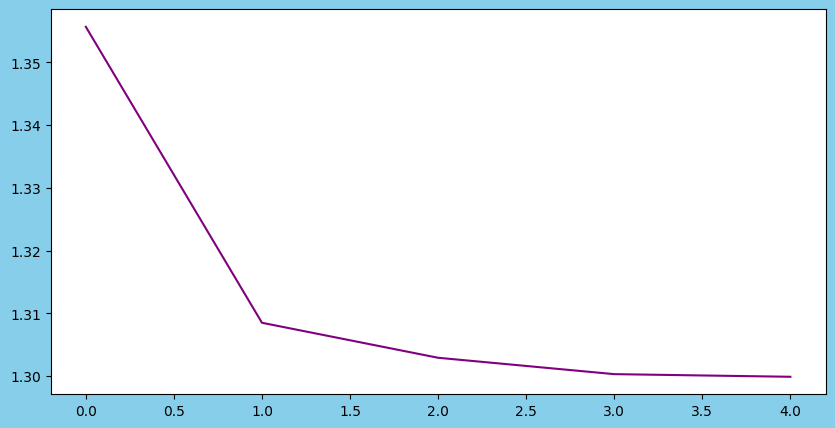

In [1729]:
loss_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
loss_ax = loss_figure.add_subplot()
loss_ax.plot(results,color= 'purple')

In [1730]:
def model_inf(model,language = 'russian',ft = dataset.tokenizer):
    """Creates a name of the given language"""
    model.eval()
    available_languages = all_categories
    #check whether language is in available languages
    if language not in available_languages:
        raise ValueError('The language is not available')
    #staring producing a name 
    current_letter_id = ft('<'+language+'>', padding = 'do_not_pad', return_tensors='pt')['input_ids']
    name = ''
    y_pred = model(current_letter_id).softmax(dim = 1)
    y_pred = y_pred.squeeze(dim = 0)
    while len(name) < 16:
        #adding a letter
        next_pred_ind = Categorical(probs=y_pred).sample([1]).item()
        if next_pred_ind == 0:
            break
        name += ft._tokenizer.id_to_token(next_pred_ind)
        #updating prediction
        y_pred = model(ft(name[-1], padding = 'do_not_pad', return_tensors='pt')['input_ids']).softmax(dim = 1).squeeze(dim = 0)
    return name

In [1731]:
for lang in all_categories:
    print(lang)
    print('--------')
    for _ in range(3):
        print(model_inf(names_rnn,language='chinese'))
    print('\n\n')

irish
--------
Gov
Rovim
Tuzd



chinese
--------
Jakimanchenkelum
kouwt
Vy



scottish
--------
Sharomjuzwaldoy
Ma
Laysov



german
--------
Kiv
Lettsulmamsontar
Roblyvarirodesha



russian
--------
Yaen
Anovell
Glikov



greek
--------
Ban
Crakhiky
Tonimi



portuguese
--------
YusodiUpento
Ralh
Jeuderieindundon



korean
--------
Pakosamachevs
Kiteiernai
Lya



dutch
--------
Kadehk
Ja
Zichatsogoyayakh



french
--------
Tikontasez
S
ZhelikyuildoDoAn



spanish
--------
Penyle
Sodmatshkyar
Zhiffercasouzo



polish
--------
Jod
Movarari
Gl



japanese
--------
ZhezorotchMuhen
Sie
Muchun



czech
--------
Covomalomsihinou
Meroto
Chein



vietnamese
--------
deronoky
Yus
Zh



arabic
--------
Zhe
Feropo
Junohts



italian
--------
Zhimanory
Drs
Roisalantaeri



english
--------
Zhky
TachehHikywakihi
Troile



